In [1]:
import os
import sys

os.chdir('/workspace/NN')

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


In [2]:
ROOT_PATH = '/workspace/NN'
DATA_PATCH = os.path.join(ROOT_PATH, 'data')
sam_checkpoint = '/workspace/NN/weights/sam/sam_vit_h_4b8939.pth'
model_type = "vit_h"
device = "cuda"


In [3]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [4]:
def image_to_mask(image_filepath, mask_gen: SamAutomaticMaskGenerator):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    masks = mask_gen.generate(image) 
    return masks, image

In [5]:
masks, image = image_to_mask(os.path.join(DATA_PATCH, 'sirius_data', f'5.jpg'), mask_generator)

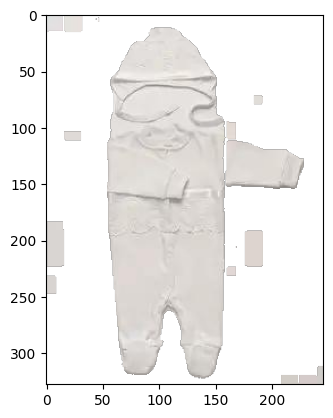

In [6]:
masks[0]['segmentation']
copy_image = image.copy()
copy_image =   np.concatenate((copy_image, np.ones_like(copy_image)[:, :, 0:1] * 255), axis=2).astype(np.uint8)
masks = sorted(masks, key=lambda x: x['area'], reverse=False)

# print(background)

background_parts = 1
full_mask = masks[0]['segmentation']
for i in masks[:-background_parts]:
    # print(type(i), i['segmentation'])
    # if i['area'] != background['area']:
    full_mask = full_mask | i['segmentation']
full_mask =  ~full_mask
copy_image[full_mask] = [0, 0, 0, 0]
plt.imshow(copy_image, interpolation_stage='rgba')



# copy_image2

(246, 328) (328, 246, 4)
(328, 246, 4) (328, 246, 4)


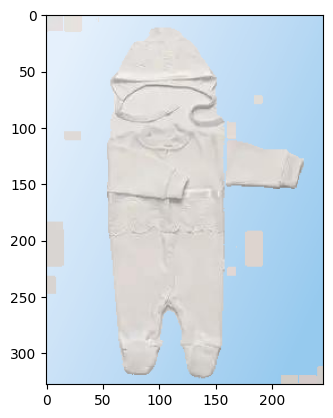

In [24]:
def crop_center(pil_img, crop_height: int, crop_width: int, ) -> Image:
    """
    Функция для обрезки изображения по центру.
    """
    img_width, img_height = pil_img.size
    
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

copy_image2 = copy_image.copy()
im = Image.open(os.path.join(ROOT_PATH, 'backgrounds', f'blue.png'))
# im.crop(copy_image2.shape[:2])
im = im.resize(copy_image2.shape[:2][::-1])
print(im.size, copy_image2.shape)

# im = crop_center(im, *copy_image2.shape[:2])
new_background = np.array(im)

# new_background = cv2.imread()
# new_background = cv2.cvtColor(new_background, cv2.COLOR_BGR2RGBA)
print(new_background.shape, copy_image2.shape)

copy_image2[copy_image2[:, :,-1] == 0] = new_background[copy_image2[:, :,-1] == 0]
plt.imshow(copy_image2, interpolation_stage='rgba')
